# 日経平均株価 15分足

### 一つ上のディレクトリをパスに追加

In [46]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

### ライブラリをここで一括インポート

In [47]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.commons import (
    get_name_15min_chart,
    get_name_15min_chart_now,
    get_name_15min_chart_usd,
)

## yfinance による株価データの取得

In [48]:
code = "N225"
symbol = f"^{code}"
ticker1 = yf.Ticker(symbol)
df = ticker1.history(period="1d", interval="15m")
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-14 09:00:00+09:00,47446.730469,47686.371094,47329.601562,47352.179688,0,0.0,0.0
2025-10-14 09:15:00+09:00,47328.550781,47853.710938,47328.550781,47842.460938,0,0.0,0.0
2025-10-14 09:30:00+09:00,47835.730469,47865.648438,47689.289062,47711.289062,0,0.0,0.0
2025-10-14 09:45:00+09:00,47711.289062,47717.761719,47469.121094,47570.171875,0,0.0,0.0
2025-10-14 10:00:00+09:00,47574.199219,47597.289062,47399.210938,47568.300781,0,0.0,0.0
2025-10-14 10:15:00+09:00,47562.781250,47718.519531,47489.011719,47651.378906,0,0.0,0.0
2025-10-14 10:30:00+09:00,47645.269531,47818.058594,47600.019531,47769.769531,0,0.0,0.0
2025-10-14 10:45:00+09:00,47757.921875,47836.800781,47731.171875,47775.398438,0,0.0,0.0
2025-10-14 11:00:00+09:00,47771.191406,47793.808594,47657.781250,47696.031250,0,0.0,0.0


## 前日終値の取得

In [49]:
# 過去一週間のデータを取得
td = datetime.timedelta(days=7)
dt_first = df.index[0]
dt_prev = dt_first - td
df_last = ticker1.history(interval="1d", start=str(dt_prev.date()))
print(df_last["Close"])
n = len(df_last)
lastclose = df_last[n - 2 : n - 1]["Close"].iloc[0]
# lastclose = 44902.27 # 9/16 終値
# 確認のため出力
df_last[n - 2 : n - 1]["Close"]

Date
2025-10-07 00:00:00+09:00    47950.878906
2025-10-08 00:00:00+09:00    47734.988281
2025-10-09 00:00:00+09:00    48580.441406
2025-10-10 00:00:00+09:00    48088.800781
2025-10-14 00:00:00+09:00    47312.128906
Name: Close, dtype: float64


Date
2025-10-10 00:00:00+09:00    48088.800781
Name: Close, dtype: float64

### 当日始値 - 前日終値

In [50]:
delta_open = df.head(1)["Open"].iloc[0] - lastclose
print(f"{delta_open:+.2f}")

-642.07


## ローソク足チャート（小さいサイズ）

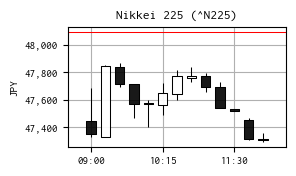

In [51]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_ylabel("JPY")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol})")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol})")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart(code, dt_first))
plt.show()

## ドル円レートで換算

In [52]:
code2 = "USDJPY=X"
symbol2 = code2
ticker2 = yf.Ticker(symbol2)

### 過去２日分のドル円レートの過去データを取得

In [53]:
# 15分足で過去 2 日分のデータを取得
df_exchange = ticker2.history(period="3d", interval="15m")
df_exchange.index = df_exchange.index.tz_convert("Asia/Tokyo")
df_exchange

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-10-10 08:00:00+09:00,153.024002,153.274994,153.022003,153.225006,0,0.0,0.0
2025-10-10 08:15:00+09:00,153.220001,153.240997,153.048004,153.072006,0,0.0,0.0
2025-10-10 08:30:00+09:00,153.072998,153.123001,153.031998,153.046997,0,0.0,0.0
2025-10-10 08:45:00+09:00,153.048004,153.091003,152.957001,153.020004,0,0.0,0.0
2025-10-10 09:00:00+09:00,153.022995,153.160004,152.959000,153.149994,0,0.0,0.0
...,...,...,...,...,...,...,...
2025-10-14 12:00:00+09:00,152.376007,152.393997,152.292007,152.313995,0,0.0,0.0
2025-10-14 12:15:00+09:00,152.311996,152.337006,152.296005,152.307999,0,0.0,0.0
2025-10-14 12:30:00+09:00,152.307999,152.315002,152.100006,152.108002,0,0.0,0.0


### 15分足の Close のドル円レートで一括割る

In [54]:
ser_rate = df_exchange.loc[df.index, "Close"]
ser_rate
df2 = pd.DataFrame()
df2["Open"] = df["Open"] / ser_rate
df2["High"] = df["High"] / ser_rate
df2["Low"] = df["Low"] / ser_rate
df2["Close"] = df["Close"] / ser_rate
df2

,Open,High,Low,Close
Datetime,,,,
2025-10-14 09:00:00+09:00,311.228150,312.800079,310.459839,310.607941
2025-10-14 09:15:00+09:00,310.216907,313.659090,310.216907,313.585351
2025-10-14 09:30:00+09:00,313.604939,313.801077,312.644888,312.789117
2025-10-14 09:45:00+09:00,312.928637,312.971090,311.340307,312.003078
2025-10-14 10:00:00+09:00,312.189179,312.340698,311.040879,312.150473
2025-10-14 10:15:00+09:00,311.936186,312.957581,311.452375,312.517246
2025-10-14 10:30:00+09:00,312.540702,313.674153,312.243873,313.357389
2025-10-14 10:45:00+09:00,313.252989,313.770370,313.077531,313.367621
2025-10-14 11:00:00+09:00,313.337957,313.486306,312.594083,312.844971


### 前日の終値のドル円レートから、前日の終値のドル換算

In [55]:
dt = df_exchange.head(1).index[0]
dt_last_close = pd.to_datetime(f"{str(dt.date())} 15:15:00+09:00")
print(dt_last_close)
last_close_usd = df_exchange.loc[dt_last_close, "Close"]
last_close_usd

2025-10-10 15:15:00+09:00


np.float64(152.84800720214844)

## ローソク足チャート（小さいサイズ）/ ドル換算チャート

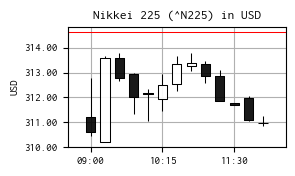

In [56]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 8

fig, ax = plt.subplots(figsize=(3, 1.8))
mpf.plot(
    df2,
    type="candle",
    style="default",
    datetime_format="%H:%M",
    xrotation=0,
    update_width_config=dict(candle_linewidth=0.75),
    ax=ax,
)
ax.axhline(y=lastclose / last_close_usd, color="red", linewidth=0.75)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.2f}'))
ax.set_ylabel("USD")
ax.grid()

if "shortName" in ticker1.info:
    ax.set_title(f"{ticker1.info['shortName']} ({symbol}) in USD")
elif "longName" in ticker1.info:
    ax.set_title(f"{ticker1.info['longName']} ({symbol}) in USD")
else:
    ax.set_title(f"{symbol}")

plt.tight_layout()
plt.savefig(get_name_15min_chart_usd(code, dt_first))
plt.show()